Before running the next cell please add a shortcut to the shared folder at the root of your Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Learning_with_Density_Matrices_and_Random_Features-Supplementary_Material/qmc/tf')
import layers as layers
import models as models

/usr/local/lib/python3.6/dist-packages/typeguard/__init__.py:804: UserWarning: no type annotations present -- not typechecking layers.CrossProduct.__init__
  warn('no type annotations present -- not typechecking {}'.format(function_name(func)))
/usr/local/lib/python3.6/dist-packages/typeguard/__init__.py:804: UserWarning: no type annotations present -- not typechecking layers.DensityMatrix2Dist.__init__
  warn('no type annotations present -- not typechecking {}'.format(function_name(func)))
/usr/local/lib/python3.6/dist-packages/typeguard/__init__.py:804: UserWarning: no type annotations present -- not typechecking layers.DensityMatrixRegression.__init__
  warn('no type annotations present -- not typechecking {}'.format(function_name(func)))


In [ ]:
import warnings
import numpy as np
from sklearn.kernel_approximation import RBFSampler

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import numpy as np
import pylab as pl
import pandas as pd
import h5py

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pickle
import gzip
import time

In [ ]:
class LenetQMKDClassifierSGD(tf.keras.Model):
    """
    A Quantum Measurement Kernel Density Classifier model trainable using
    gradient descent.

    Arguments:
        input_dim: dimension of the input
        dim_x: dimension of the input quantum feature map
        num_classes: number of classes
        num_eig: Number of eigenvectors used to represent the density matrix.
                 a value of 0 or less implies num_eig = dim_x
        gamma: float. Gamma parameter of the RBF kernel to be approximated
        random_state: random number generator seed
    """
    def __init__(self, input_dim, dim_x, num_classes,  num_eig=0, gamma=1, random_state=None, fm_x=None):
        super(LenetQMKDClassifierSGD, self).__init__()

        self.conv_2d_1 = tf.keras.layers.Conv2D(filters=20, kernel_size=(5, 5), padding="same", activation='relu', input_shape=(input_dim, input_dim, 1))
        self.average_pooling_2d_1 = tf.keras.layers.AveragePooling2D()

        self.conv_2d_2 = tf.keras.layers.Conv2D(filters=50, kernel_size=(5, 5), padding="same", activation='relu')
        self.average_pooling_2d_2 = tf.keras.layers.AveragePooling2D()

        self.flatten = tf.keras.layers.Flatten()

        # self.dense_1 = tf.keras.layers.Dense(units=500, activation='relu')
        self.dense_1 = tf.keras.layers.Dense(units=84, activation='relu')

        # self.dense_2 = tf.keras.layers.Dense(units=84, activation='relu')

        if fm_x is None:
            self.fm_x = layers.QFeatureMapORF(
                input_dim=84,
                dim=dim_x, gamma=gamma, random_state=random_state)
        else:
            self.fm_x = fm_x
        self.dim_x = dim_x
        self.num_classes = num_classes
        self.qmd = []
        for _ in range(num_classes):
            self.qmd.append(layers.QMeasureDensityEig(dim_x, num_eig))
        self.gamma = gamma
        self.random_state = random_state

        
    def call(self, inputs):
        model = self.conv_2d_1(inputs)
        model = self.average_pooling_2d_1(model)
        model = self.conv_2d_2(model)
        model = self.average_pooling_2d_2(model)
        model = self.flatten(model)
        model = self.dense_1(model)
        # model = self.dense_2(model)


        psi_x = self.fm_x(model)
        probs = []
        for i in range(self.num_classes):
            probs.append(self.qmd[i](psi_x))
        posteriors = tf.stack(probs, axis=-1)
        posteriors = (posteriors /
                      tf.expand_dims(tf.reduce_sum(posteriors, axis=-1), axis=-1))
        return posteriors

    def set_rhos(self, rhos):
        for i in range(self.num_classes):
            self.qmd[i].set_rho(rhos[i])
        return


    def get_config(self):
        config = {
            "dim_x": self.dim_x,
            "num_classes": self.num_classes,
            "num_eig": self.num_eig,
            "gamma": self.gamma,
            "random_state": self.random_state
        }
        base_config = super().get_config()
        return {**base_config, **config}


In [ ]:
class Lenet(tf.keras.Model):
    """
    A Lenet model
    """
    def __init__(self):
        super(Lenet, self).__init__()

        self.conv_2d_1 = tf.keras.layers.Conv2D(filters=20, kernel_size=(5, 5), padding="same", activation='relu', input_shape=(input_dim, input_dim, 1))
        self.average_pooling_2d_1 = tf.keras.layers.AveragePooling2D()

        self.conv_2d_2 = tf.keras.layers.Conv2D(filters=50, kernel_size=(5, 5), padding="same", activation='relu')
        self.average_pooling_2d_2 = tf.keras.layers.AveragePooling2D()

        self.flatten = tf.keras.layers.Flatten()

        # self.dense_1 = tf.keras.layers.Dense(units=500, activation='relu')
        self.dense_1 = tf.keras.layers.Dense(units=84, activation='relu')

        # self.dense_2 = tf.keras.layers.Dense(units=84, activation='relu')

        self.softmax = tf.keras.layers.Dense(units=10, activation = 'softmax')

        
    def call(self, inputs):
        model = self.conv_2d_1(inputs)
        model = self.average_pooling_2d_1(model)
        model = self.conv_2d_2(model)
        model = self.average_pooling_2d_2(model)
        model = self.flatten(model)
        model = self.dense_1(model)
        # model = self.dense_2(model)

        return self.softmax(model)

## Dataset


In [ ]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape((60000,784))
X_test = X_test.reshape((10000,784))
#%%

# random_train = np.random.choice(range(train['features'].shape[0]), 60000, replace=False)
# random_test = np.random.choice(range(test['features'].shape[0]), 10000, replace=False)

#%%


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print("shape X_train : ", X_train.shape)
print("shape y_train : ", y_train.shape)
print("shape X_test : ", X_test.shape)
print("shape y_test : ", y_test.shape)

shape X_train :  (60000, 784)
shape y_train :  (60000,)
shape X_test :  (10000, 784)
shape y_test :  (10000,)


In [ ]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(60000, 784)
(60000,)


In [ ]:
#from sklearn.ensemble import RandomForestClassifier

#clf = RandomForestClassifier()
#clf.fit(X_train, y_train)
#print(clf.score(X_test, y_test))

In [ ]:
#from sklearn.ensemble import GradientBoostingClassifier

#clf = GradientBoostingClassifier()
#clf.fit(X_train, y_train)
#print(clf.score(X_test, y_test))

In [ ]:
input_dim = 784
component_dim = 1000
num_classes = 10
gamma = 2**-5
random_state=0
num_eig=0
#num_eig=0
batch_size=16
epochs=20
learning_rate=0.0001
decay=0

In [ ]:
gammas = [2**i for i in range(-12,-2)]
componets_dim = [int(input_dim*1/5),int(input_dim*1/3),int(input_dim*1/2), input_dim*1,input_dim*2,input_dim*4,input_dim*8,input_dim*16,input_dim*32, input_dim*64, 1000]

num_eigs = [0] + [2**i for i in range(int(np.log2(component_dim)))]
scores = {}

In [ ]:
num_eigs

[0, 1, 2, 4, 8, 16, 32, 64, 128, 256]

In [ ]:
name_file = 'mnist_qmc_lenet.pkl'

In [ ]:
# with open(name_file, 'rb') as f:
#    scores = pickle.load(f)

In [ ]:
# scores

In [ ]:
def create_model(input_dim, num_classes, y_train, y_test, component_dim=100, gamma=1, lr=0.01, decay=0.,
                  random_state=None, eig_percentage=0, initialize_with_rff=False,
                  type_of_rff="rff", fix_rff=False):
    '''This is a model generating function so that we can search over neural net
    parameters and architecture'''

    num_eig = round(eig_percentage * component_dim)

    opt = tf.keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, decay=decay)

    if type_of_rff == 'rff':
        fm_x = layers.QFeatureMapRFF(84, dim=component_dim, gamma=gamma, random_state=random_state)
    else:
        fm_x = layers.QFeatureMapORF(84, dim=component_dim, gamma=gamma, random_state=random_state)

    if initialize_with_rff:
        qmkdc = models.QMKDClassifier(fm_x=fm_x, dim_x=component_dim, num_classes=num_classes)
        qmkdc.compile()
        qmkdc.fit(X_train, y_train, epochs=1, batch_size=batch_size)

    qmkdc1 = LenetQMKDClassifierSGD(input_dim=round(np.sqrt(input_dim)), dim_x=component_dim, num_eig=num_eig,
                                      num_classes=num_classes, gamma=gamma, random_state=random_state, fm_x=fm_x)
    
    if fix_rff:
        qmkdc1.layers[0].trainable = False

    qmkdc1.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=opt, metrics=['accuracy'])

    if initialize_with_rff:
        qmkdc1.set_rhos(qmkdc.get_rhos())

    # qmkdc1.fit(X_train, y_train_bin, epochs=epochs, batch_size=batch_size)

    return qmkdc1, tf.reshape(tf.keras.backend.one_hot(y_train, num_classes), (-1, num_classes)), tf.reshape(tf.keras.backend.one_hot(y_test, num_classes), (-1, num_classes)) 

In [ ]:
def save_model_results(name_file, scores, experiment):  
  count = 0.0001
  while True:
    try:
      aux = scores[experiment].copy()
      with open(name_file, 'rb') as f:
        scores = pickle.load(f)
      with open(name_file, 'wb') as f:
        print(scores)
        scores[experiment] = aux
        pickle.dump(scores, f)
        break
    except:
      time.sleep(count)
      print("error saving")
      count = count * 10

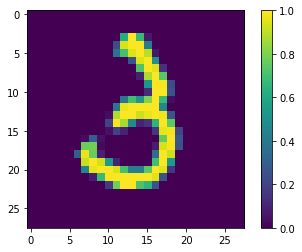

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train.reshape(-1,28,28)[100,:,:])
plt.colorbar()

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
model_mnist.summary()

In [ ]:
gamma=2**-12
experiment="lenet_rff"

model_mnist, y_train_mod, y_test_mod = create_model(input_dim, num_classes, y_train, y_test, component_dim=component_dim, gamma=gamma, lr=learning_rate, decay=decay,
                  random_state=None, eig_percentage=0, initialize_with_rff=False,
                  type_of_rff="rff", fix_rff=False)



In [ ]:
for i in range(20):
  model_mnist.fit(X_train.reshape(-1,28,28,1), y_train_mod, epochs=1, batch_size=32)

  out = model_mnist.predict(X_test.reshape(-1,28,28,1))
  print(accuracy_score(y_test, out.argmax(axis=1)))
  model_mnist.save_weights("/gdrive/My Drive/20201102_lenet_weights.pkl")

In [ ]:
#model_mnist.save_weights("/gdrive/My Drive/lenet_weights.pkl")
model_mnist.load_weights("/gdrive/My Drive/lenet_weights.pkl")

In [ ]:
out = model_mnist.predict(X_test.reshape(-1,28,28,1))
accuracy_score(y_test, out.argmax(axis=1))

0.9907

In [ ]:
accuracy_score(y_test, out.argmax(axis=1))

0.987

In [ ]:
accuracy_score(y_test, out.argmax(axis=1))

0.7049

In [ ]:
model.fit(X_train.reshape(-1,28,28,1), y_train_mod, epochs=100, batch_size=32)

In [ ]:
out = model.predict(X_test.reshape(-1,28,28,1))
accuracy_score(y_test, out.argmax(axis=1))

0.9918

In [ ]:
# model2 = Lenet()
# model2.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, decay=decay), metrics=['accuracy'])
model2.fit(X_train.reshape(-1,28,28,1), y_train_mod, epochs=50, batch_size=32)

Epoch 1/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0305 - accuracy: 0.9910
Epoch 2/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0306 - accuracy: 0.9912
Epoch 3/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0298 - accuracy: 0.9910
Epoch 4/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0297 - accuracy: 0.9911
Epoch 5/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0295 - accuracy: 0.9914
Epoch 6/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0291 - accuracy: 0.9914
Epoch 7/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0288 - accuracy: 0.9914
Epoch 8/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0283 - accuracy: 0.9914
Epoch 9/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0281 - accuracy: 0.9919
Epoch 10/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.028

In [ ]:
out = model2.predict(X_test.reshape(-1,28,28,1))
accuracy_score(y_test, out.argmax(axis=1))

0.9869